In [1]:
from gravhydro import Simulation
from galpy.potential import PlummerPotential
from galpy.df import isotropicPlummerdf
from astropy import units as u
import numpy as np
import time
from pynbody.analysis.profile import Profile

In [2]:
import matplotlib.pyplot as plt

In [3]:
totalMass = 1e5 *u.Msun
plummer = PlummerPotential(amp = totalMass , b=(1*u.pc).to(u.kpc))
df = isotropicPlummerdf(pot = plummer)
n_pts = 5000
masses = np.ones(n_pts) * totalMass/n_pts
sample =  df.sample(n=n_pts)
q = np.zeros((n_pts, 3)) 
v = np.zeros((n_pts, 3)) 
q[:,0] = sample.x()
q[:,1] = sample.y()
q[:,2] = sample.z()
v[:,0] = sample.vx()
v[:,1] = sample.vy()
v[:,2] = sample.vz()
v *= u.km / u.s
q *= u.kpc

In [4]:
q[:,0].shape

(5000,)

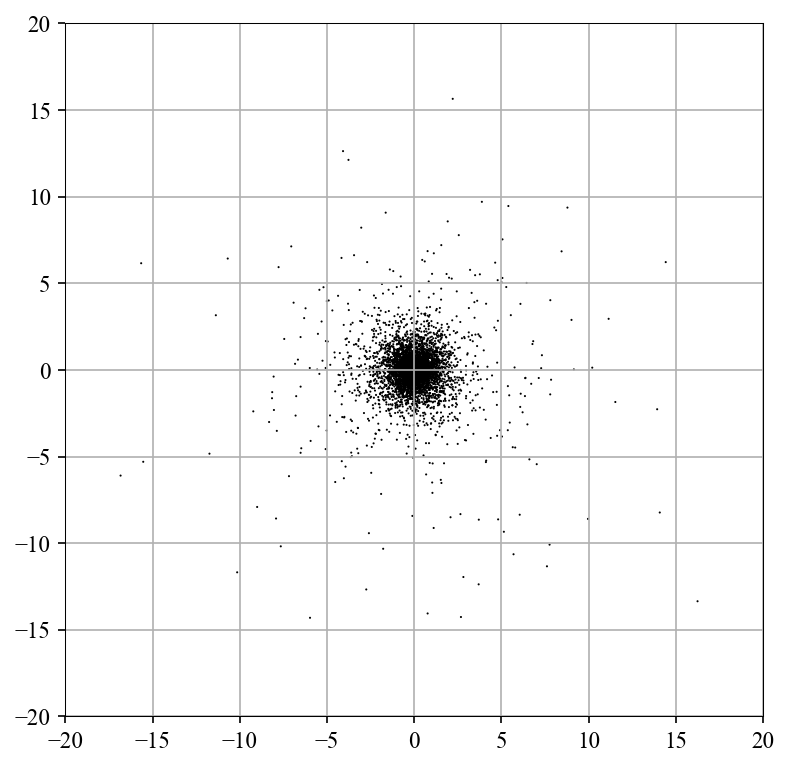

In [5]:
plt.figure(figsize=(6,6), dpi=150)
plt.scatter(q[:,0].to(u.pc).value, q[:,1].to(u.pc).value, s=1)
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.grid(True)

In [6]:
# plt.figure(figsize=(6,6), dpi=150)
# plt.scatter(v[:,0].to(u.km/u.s).value, v[:,1].to(u.km/u.s).value, s=1)
# plt.grid(True)
# plt.xlim(-80, 80)
# plt.ylim(-80, 80)
# plt.show()

In [7]:
masses

<Quantity [20., 20., 20., ..., 20., 20., 20.] solMass>

In [ ]:
dt = 5e3 * u.yr
n_steps = 100
ts = np.linspace(0, n_steps*dt, n_steps) 

In [10]:
ts

<Quantity [     0.        ,   5050.50505051,  10101.01010101,
            15151.51515152,  20202.02020202,  25252.52525253,
            30303.03030303,  35353.53535354,  40404.04040404,
            45454.54545455,  50505.05050505,  55555.55555556,
            60606.06060606,  65656.56565657,  70707.07070707,
            75757.57575758,  80808.08080808,  85858.58585859,
            90909.09090909,  95959.5959596 , 101010.1010101 ,
           106060.60606061, 111111.11111111, 116161.61616162,
           121212.12121212, 126262.62626263, 131313.13131313,
           136363.63636364, 141414.14141414, 146464.64646465,
           151515.15151515, 156565.65656566, 161616.16161616,
           166666.66666667, 171717.17171717, 176767.67676768,
           181818.18181818, 186868.68686869, 191919.19191919,
           196969.6969697 , 202020.2020202 , 207070.70707071,
           212121.21212121, 217171.71717172, 222222.22222222,
           227272.72727273, 232323.23232323, 237373.73737374,
        

In [9]:
sim = Simulation()
start = time.time()
sim.run(q.copy(), v.copy(), masses, ts, 
                            gravityMethod='directSummation', use_numba=True)
t_numba = time.time() - start
print(f"Direct (Numba): {t_numba:.3f}s")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


TypeError: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'

# Density Profile

In [ ]:
sim.pynbodySnap(0)

<SimSnap "<created>" len=5000>

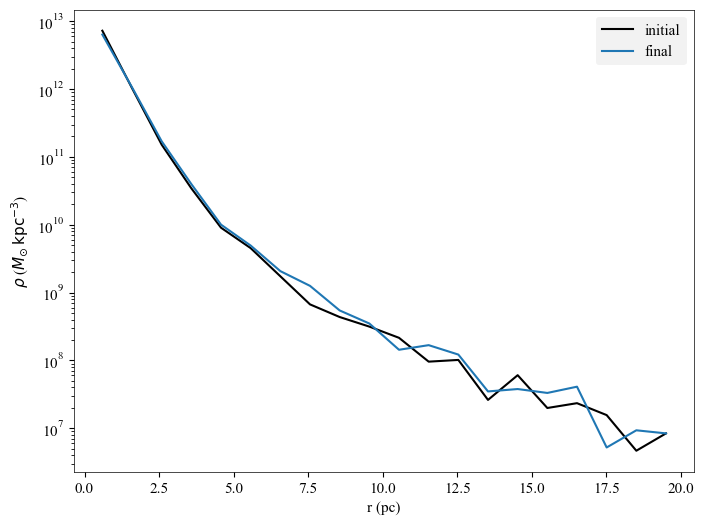

In [ ]:
# Plot density profile before and after
s_IC = sim.pynbodySnap(0)
s_final = sim.pynbodySnap(-1)
p_IC = Profile(s_IC, ndim=3, min=0.0001, max=0.02, nbins=20)
p_final = Profile(s_final, ndim=3, min=0.0001, max=0.02, nbins=20)
plt.plot(p_IC['rbins'].in_units('pc'), p_IC['density'], label='initial')
plt.plot(p_final['rbins'].in_units('pc'), p_final['density'], label='final')
plt.yscale('log')
plt.xlabel('r (pc)')
plt.ylabel(f'$\\rho$ (${p_IC["density"].units.latex()}$)')
plt.legend()

In [12]:
# # Plot density profile before and after
# s_IC = sim.pyn_snap(timestep=0)
# s_final = sim.pyn_snap()
# p_IC = Profile(s_IC, ndim=3, min=0.0001, max=0.02, nbins=20)
# p_final = Profile(s_final, ndim=3, min=0.0001, max=0.02, nbins=20)
# plt.plot(p_IC['rbins'].in_units('pc'), p_IC['density'], label='initial')
# plt.plot(p_final['rbins'].in_units('pc'), p_final['density'], label='final')
# plt.yscale('log')
# plt.xlabel('r (pc)')
# plt.ylabel(f'$\\rho$ (${p_IC["density"].units.latex()}$)')
# plt.legend()

# Animation

In [13]:
import plotly.graph_objects as go

# Get snapshots at regular intervals
n_frames = 20
frame_indices = np.linspace(0, len(sim.time) - 1, n_frames, dtype=int)

# Sample every nth particle
particle_step = 10

# Determine axis limits from all frames
all_coords = []
for idx in frame_indices:
    #snap = sim.pyn_snap(timestep=idx)
    all_coords.extend(sim.x(idx)[::particle_step].value)
    all_coords.extend(sim.y(idx)[::particle_step].value)
    all_coords.extend(sim.z(idx)[::particle_step].value)
max_range = max(abs(min(all_coords)), abs(max(all_coords))) * 0.05

# Create frames for animation
frames = []
for i, idx in enumerate(frame_indices):
    #snap = sim.pyn_snap(timestep=idx)
    x = sim.x(idx)[::particle_step].value
    y = sim.y(idx)[::particle_step].value
    z = sim.z(idx)[::particle_step].value
    
    frames.append(go.Frame(
        data=[go.Scatter3d(
            x=x, y=y, z=z,
            mode='markers',
            marker=dict(size=2, color='black', opacity=0.6)
        )],
        name=str(i)
    ))

# Initial data
# snap_init = sim.pyn_snap(timestep=0)
x0 = sim.x(0)[::particle_step].value
y0 = sim.y(0)[::particle_step].value
z0 = sim.z(0)[::particle_step].value

# Create figure
fig = go.Figure(
    data=[go.Scatter3d(
        x=x0, y=y0, z=z0,
        mode='markers',
        marker=dict(size=2, color='black', opacity=0.6)
    )],
    layout=go.Layout(
        title='Plummer Sphere Evolution',
        scene=dict(
            xaxis_title='x (kpc)',
            yaxis_title='y (kpc)',
            zaxis_title='z (kpc)',
            xaxis=dict(range=[-max_range, max_range]),
            yaxis=dict(range=[-max_range, max_range]),
            zaxis=dict(range=[-max_range, max_range]),
            aspectmode='cube'
        ),
        updatemenus=[dict(
            type='buttons',
            showactive=False,
            buttons=[
                dict(label='Play',
                     method='animate',
                     args=[None, dict(frame=dict(duration=100, redraw=True),
                                      fromcurrent=True, mode='immediate')]),
                dict(label='Pause',
                     method='animate',
                     args=[[None], dict(frame=dict(duration=0, redraw=False),
                                        mode='immediate')])
            ]
        )],
        sliders=[dict(
            steps=[dict(method='animate',
                        args=[[str(i)], dict(mode='immediate',
                                             frame=dict(duration=100, redraw=True))],
                        label=str(i)) for i in range(len(frames))],
            active=0,
            transition=dict(duration=0),
            currentvalue=dict(prefix='Frame: ')
        )]
    ),
    frames=frames
)

fig.show()